# EGM722 - Week 4 Practical: Raster data using rasterio

## Overview
Up to now, you have gained some experience working with basic features of python, used cartopy and matplotlib to create a map, and explored using shapely and geopandas to work with vector data. In this week's practical, we'll be looking at working with raster data using rasterio and numpy.

## Objectives
-  Learn about opening and viewing raster data using rasterio and cartopy
-  Become familiar with opening files using a `with` statement
-  Use `*` and `**` to unpack arguments in a function
-  Use rasterio to reproject raster data

## Data provided

In the `data_files` folder, you should have the following files:
-  NI\_mosaic.tif

## 1. Getting started
In this practical, we'll be working with raster data. As a quick refresher, raster data are gridded datasets that contain anything from aerial and satellite images to elevation, temperature, or classisfied land cover. A raster is made up of pixels (or cells), where each pixel value represents the dataset's value at a given location.

To get started, run the following cell to import rasterio and matplotlib.

In [19]:
%matplotlib inline

import numpy as np
import rasterio as rio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In the box below, we load the dataset using `rio.open()`, then view some of the attributes of the dataset. 

`rio.open()` creates a [__DatasetReader__](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader) object that we use to read the dataset and its attributes. When we do this, we don't actually load the full raster into memory - we just open the file and read the metadata and other attributes. Later on, we'll load the raster into memory; for now, we'll look at the different attributes of the __DatasetReader__ object.

For starters, the `name` attribute is the filename for the dataset, and the `mode` refers to how the dataset has been opened (`r` for read, `w` for write, `r+` for read/write). We can also check how many _layers_, or _bands_, the datset has using `count`, and check the size of the image using `width` and `height`. Finally, we can see the different types of data (e.g., integer, floating point, etc.) that each band has using `dtypes`.

In [20]:
dataset = rio.open('data_files/NI_Mosaic.tif')

print('{} opened in {} mode'.format(dataset.name,dataset.mode))
print('image has {} band(s)'.format(dataset.count))
print('image size (width, height): {} x {}'.format(dataset.width, dataset.height))
print('band 1 dataype is {}'.format(dataset.dtypes[0])) # note that the band name (Band 1) differs from the list index [0]

data_files/NI_Mosaic.tif opened in r mode
image has 7 band(s)
image size (width, height): 1850 x 1500
band 1 dataype is int16


We can also look at the georeferencing information for the dataset. The `bounds` attribute gives locations for the left, bottom, right, and top sides of the image:

In [21]:
print(dataset.bounds)

BoundingBox(left=550000.0, bottom=5985000.0, right=735000.0, top=6135000.0)


Note that these values are in the coordinate reference system (CRS) of the dataset, which we can view using the `crs` attribute:

In [22]:
print(dataset.crs)

EPSG:32629


This dataset has a CRS of __EPSG:32629__, which corresponds to WGS84 UTM Zone 29N. 

Finally, the `transform` of a dataset is a 3x3 affine transformation matrix:

In [23]:
print(dataset.transform)

| 100.00, 0.00, 550000.00|
| 0.00,-100.00, 6135000.00|
| 0.00, 0.00, 1.00|


The  maps pixel locations to real-world coordinates. The matrix has the following form:

```
| a b c |
| d e f |
| g h i |
```

where:

- _a_ corresponds to the pixel width;
- _b_ is the row rotation (normally 0); 
- _c_ is the x coordinate of the upper-left corner of the image;
- _d_ is the column rotation (normally 0);
- _e_ is the pixel height;
- _f_ is the y coordinate of the upper-left corner of the image;
- _g_
- _h_
- _i_

## 2. Loading the data
To load the data, we use the `read()` [method](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) of the __DatasetReader__ object. This returns a [numpy](https://numpy.org/doc/stable/) array:

In [24]:
img = dataset.read()

By default, `read()` will load all of the bands associated with the dataset. To load specific bands, we can pass individual indices, or a list of indices, that we want to load (e.g., `dataset.read(1)` to load the first band or `dataset.read([1, 2])` to load the first 2 bands). 

Note that when we pass indices to the `read()` method, we start indexing from 1, rather than 0. This is not the case for the array that is returned, however - here, the indices start from 0. This can be confusing, so it's good to pay attention to what kind of object you are working with when you start indexing.

In [25]:
print(img.shape) # returns a tuple with the number of image bands bands, image height, and image width.
print(img[6]) # will return an IndexError, because while there are 7 bands, the indices range from 0 to 6.

(7, 1500, 1850)
[[ 52  45  45 ...   0   0   0]
 [ 44  43  47 ...   0   0   0]
 [ 43  40  45 ...   0   0   0]
 ...
 [771 835 826 ...  63  56  46]
 [678 739 842 ...  49  50  50]
 [579 588 788 ...  57  46  56]]


If we want to get a specific pixel value, we can index the array just like we would a __list__ or __tuple__. For example, to get the value of the center pixel in Band 1, we can do the following. For the arrays that we are using, the first index corresponds to the band (if there's more than one band), the second index (first index if there's only one band) corresponds to the row (y) location, and the third (second) index corresponds to the column (x) location:

In [26]:
print(img[0, dataset.height // 2, dataset.width // 2]) # note that // performs floor division, as indices have to be integers

375


Using the __DatasetReader__ object, we can also find the pixel indices corresponding to spatial locations, and vice-versa, using both the `index()` method and the `transform` attribute. Note that the spatial locations should be in the same CRS as the image transform - if they are not, the image indices returned might not make sense:

In [27]:
centeri, centerj = dataset.height // 2, dataset.width // 2 # note that centeri corresponds to the row, and centerj the column
centerx, centery = dataset.transform * (centerj, centeri) # note the reversal here, from i,j to j,i
print(dataset.index(centerx, centery))
print((centeri, centerj) == dataset.index(centerx, centery)) # check that these are the same

(750, 925)
True


If we don't want to load the whole image at once, we can also choose a `window` using `read`. The format for this is a __tuple__ of __tuples__ corresponding to the top/bottom indices and left/right indices of the window. We can combine this with `index()` to load a subset of the image based on spatial location (for example, using a vector dataset). Here, we can select a 1 km window around the center pixel:

In [29]:
top, lft = dataset.index(centerx-500, centery+500)
bot, rgt = dataset.index(centerx+500, centery-500)

subset = dataset.read(window=((top, bot), (lft, rgt))) # format is (top, bottom), (left, right)

dataset.close() # remember to close the dataset now that we're done with it.

RasterioIOError: Dataset is closed: data_files/NI_Mosaic.tif

## 3. The with statement
In python, we use the built-in `open()` function to open files on the disk, in almost exactly the same way that `rasterio.open()` works. If you were to run the line of code below, you would see an output like this:

```python
In [42]: dataset
Out[42]: <open DatasetReader name='data_files/NI_Mosaic.tif' mode='r'>
```

Here, the file is `open`, with a mode `r` for reading. Once we are done with the file (either reading, writing, appending, or whatever it happens to be), we have to remember to _close_ the file using the `close()` method:

```python
f = open('my_file.txt', 'w')
...
f.close()
```

However, sometimes things happen. For example, an exception might be raised, or the interpreter might crash, and the file might [stay open](https://askubuntu.com/a/701536).

One way that we can handle opening/closing files without having to remember to explicitly close them is using a `with` statement:

```python
with open('my_file.txt', 'w') as f:
    ...
```

This is exactly the same as what's written above - within the `with` statement, we can use the variable `f` exactly as we would in the other example. In the cell below, we can re-open the dataset, extract the different attributes that we will need for the next few exercises, and then close the file:

In [35]:
with rio.open('data_files/NI_Mosaic.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

You should see that `dataset` is now a _closed_ __DatasetReader__ object:

In [36]:
dataset

<closed DatasetReader name='data_files/NI_Mosaic.tif' mode='r'>

## 4. Displaying raster data using matplotlib and cartopy

Now that we've loaded our image, we can use cartopy and matplotlib to display it, just like we did for mapping vector data in Weeks 2 and 3. To start, we'll create a new cartopy __CRS__ object, and use this to create a matplotlib __Axes__ object:

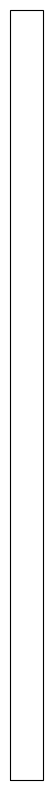

In [37]:
myCRS = ccrs.UTM(29) # note that this matches with the CRS of our image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

Now, we will use [`ax.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) to display a single band from our image. We'll use the [Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products) Near Infrared band - for our image, which is based on Landsat 5 TM images, this is Band 4 (remember that this corresponds to index 3 of our bands array):

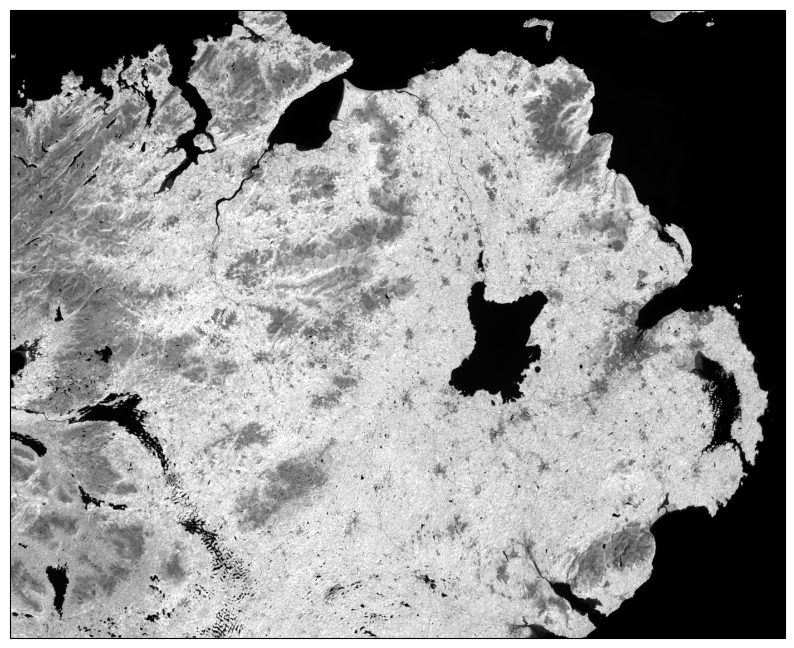

In [38]:
ax.imshow(img[3], cmap='gray', vmin=200, vmax=5000)

fig

As you can see from the link above, `imshow()` has a number of arguments that we can use to display our image. As we are using only a single band, we can set the minimum (`vmin`) and maximum (`vmax`) values of the image to stretch the display to, as well as what colormap to use (`cmap`). For more information about colormaps, you can check out [this tutorial](https://matplotlib.org/stable/tutorials/colors/colormaps.html), as well as a recent [paper](https://www.nature.com/articles/s41467-020-19160-7) on the (mis)use of color in science.

But, mouse over the figure window above - what coordinates do you see in the bottom right corner? Do they look correct? By default, `imshow()` uses the row/column indices of the image, rather than the geographic coordinates. To set these properly, we have to tell `imshow()` both the `tranform` (CRS) to use, as well as the `extent` of the image. Run the cell below, then mouse back over the figure above. The coordinates (both the projected and geographic coordinates) should look more correct now.

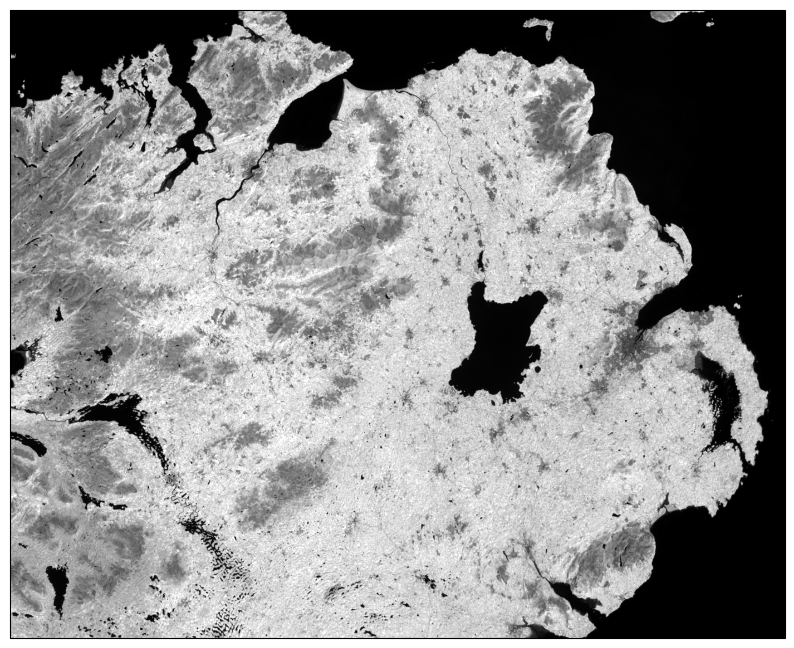

In [39]:
ax.imshow(img[3], cmap='gray', vmin=200, vmax=5000, transform=myCRS, extent=[xmin, xmax, ymin, ymax])

fig

This is not the only way that we can display images, however. We can also display them as RGB color composites. Try the following code:

In [40]:
ax.imshow(img[0:3], transform=myCRS, extent=[xmin, xmax, ymin, ymax])

fig

TypeError: Invalid shape (3, 1500, 1850) for image data

So that didn't work - we get a __TypeError__ with the following message:

```python
TypeError: Invalid shape (3, 1500, 1850) for image data
```


Remember that `dataset.read()` loaded the raster as a raster with three dimensions:

- dimension 1: the bands
- dimension 2: the rows
- dimension 3: the columns

But, `ax.imshow()` expects that the image indices are in the order (rows, columns, bands). From the documentation, we also see that:

```
	
X: array-like or PIL image
    The image data. Supported array shapes are:

    (M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. 
        See parameters norm, cmap, vmin, vmax.
    (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
    The first two dimensions (M, N) define the rows and columns of the image.

    Out-of-range RGB(A) values are clipped.
```

So, to show an RGB image, we also need to scale our image to have values between 0-1 (or 0-255). 

Now, we could try do this each and every time that we want to display an image, but this makes for unreadable code and also increases the likelihood that we will make a mistake writing our code. 

In other words, this is a perfect place to write a function:

In [41]:
def img_display(image, ax, bands, transform, extent):
    '''
    This is where you should write a docstring.
    '''
    # first, we transpose the image to re-order the indices
    dispimg = image.transpose([1, 2, 0])
    
    # next, we have to scale the image.
    dispimg = dispimg / dispimg.max()
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

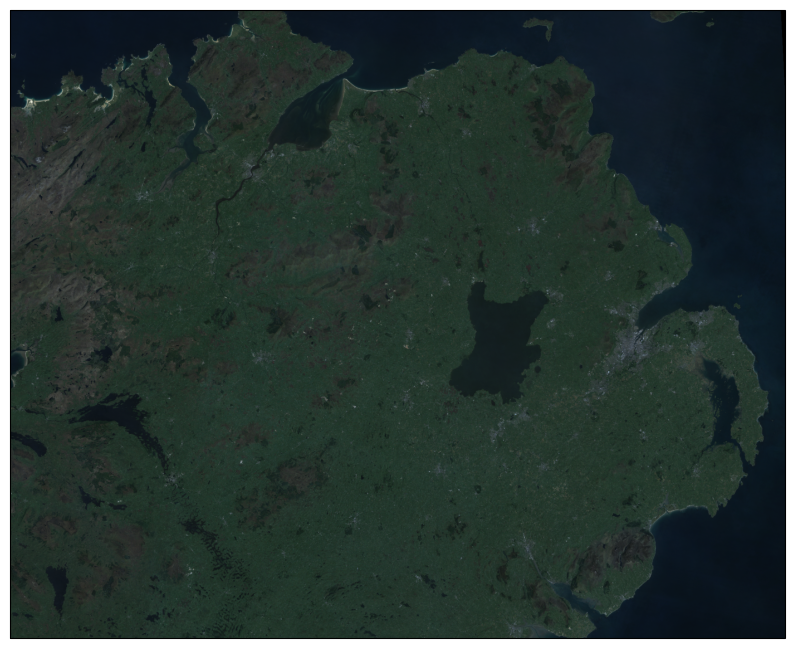

In [47]:
h, ax = img_display(img, ax, [2, 1, 0], myCRS, [xmin, xmax, ymin, ymax])
fig # just to save you from scrolling back up to see

So that worked, but the image is very dark - this is because of the way the we "normalized" the values to fall between 0 and 1, using the maximum of all of the bands: 

In [43]:
maxvals = [img[i].max() for i in range(dataset.count)]
print(maxvals)

[2574, 3473, 4110, 6309, 8659, 3010, 6127]


From the code below, we see that not all of the bands have the same range of values. Bands 1-3 have fairly low maximum values (2500-4100), while Band 5 has the highest values of all, over twice as high as in bands 1-3. 

Rather than normalizing using the maximum value of all of the bands, we might want to instead normalize based on the maximum value of a given band. However, that might still result in dark or washed-out images. 

Let's instead try a [percentile stretch](https://theailearner.com/2019/01/30/contrast-stretching/), which should give a bit nicer results:

In [44]:
def percentile_stretch(image, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
    
    minval = np.percentile(image, pmin)
    maxval = np.percentile(image, pmax)
    
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
    
    return stretched

Here, we have a few things happening. In the function header, we have two parameters, _pmin_ and _pmax_, that we provide default values of 0 and 100, respectively:

```python
def percentile_stretch(image, pmin=0, pmax=100):
    ...
```
    
We've seen this before, but it's worth re-stating here that if we call the function like this:

```python
    stretched = percentile_stretch(img)
```

It will use the default values for _pmin_ and _pmax_. Using default values like this provides us a way to make sure that necessary parameters are always set, without us always having to remember to set them when we call a function.

Next, note the two conditional statements at the beginning of the function:

```python
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
```

We first check that pmin >= 0 (because it's a percentage), that pmin < pmax, and that pmax <= 100 (because it's a percentage). 

If any of these things are not true, we __raise__ a __ValueError__, with a message indicating what caused the error. 

We also want to make sure that our image only has two dimensions (i.e., we are operating on a single band), so we check that the number of dimensions (`ndim`) is equal to 2:

```python
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
```

After that, we use [`np.percentile()`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to calculate the percentile value:

```python
    minval = np.percentile(image, pmin)
    maxval = np.percentile(image, pmax)
```

stretch the image to values between 0 and 1:

```python
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
```

and make sure to set any values below our minimum/maximum values to be equal to 0 or 1, respectively:

```python
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
```
    
Now, we should update `img_display()` to use `percentile_stretch()`:

In [45]:
def img_display(image, ax, bands, transform, extent, pmin=0, pmax=100):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        dispimg[b] = percentile_stretch(image[b], pmin=pmin, pmax=pmax)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

Now, run the new function:

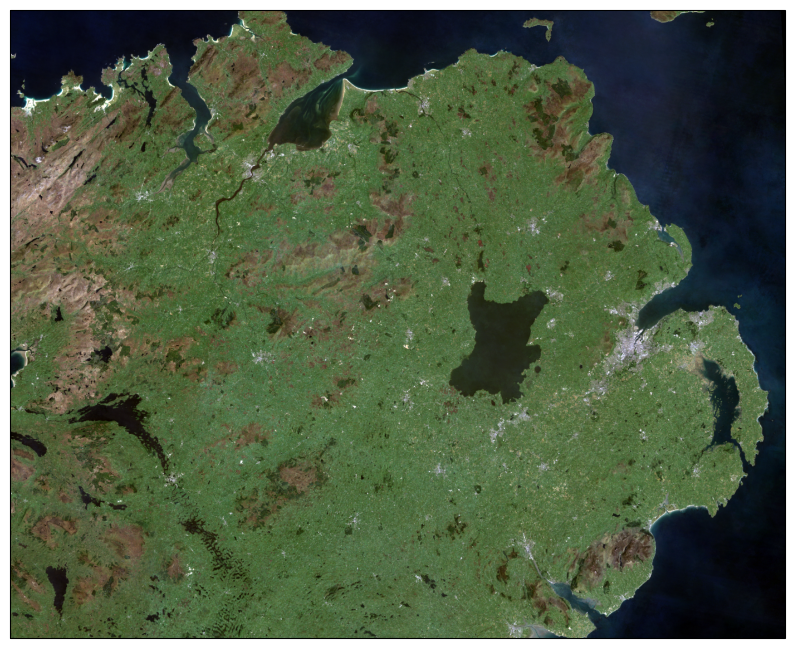

In [46]:
h, ax = img_display(img, ax, [2, 1, 0], myCRS, [xmin, xmax, ymin, ymax], pmin=0.1, pmax=99.9)
fig # just to save you from scrolling back up to see

That looks much better - we can now see the image, it has good contrast, and the image is displayed in the correct location on the map.

## 5. functions with \*args and \*\*kwargs

At the moment, however, our function has a lot of extra parameters/arguments:

```python
def img_display(image, ax, bands, transform, extent, pmin=0, pmax=100):
    ...
```

Rather than explicitly specifying the transform and extent each time, for example, we can change this to use the [unpacking operator](https://realpython.com/python-kwargs-and-args/), `**`. In this way, we can define a __dict__ of keyword arguments (kwargs) to pass to `percentile_stretch()` and `ax.imshow()`:

In [ ]:
def new_img_display(image, ax, bands, stretch_args=None, **imshow_args):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        if stretch_args is None: # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(image[b])
        else:
            dispimg[b] = percentile_stretch(image[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)
    
    return handle, ax

Now, create a __dict__ called my_kwargs with keys `extent` and `transform`, using the values we passed to `ax.imshow()` previously:

In [ ]:
my_kwargs = {'extent': [xmin, xmax, ymin, ymax],
             'transform': myCRS}

my_stretch = {'pmin': 0.1, 'pmax': 99.9}

h, ax = new_img_display(img, ax, [2, 1, 0], stretch_args=my_stretch, **my_kwargs)
fig

You should see that this is the same image as before - the only thing that's changed is how we call the function. 

Feel free to try different stretch values, to see how it changes the image. If you're interested in learning more about Landsat [band combinations](https://youtu.be/jc8NVHwjhlQ) and [image enhancement](https://youtu.be/LYVi7F4U8Eg) in general, you are welcome to watch the lecture videos provided by these links.

## 6. Reprojecting rasters using rasterio
Fortunately, our image was provided in a geographic format that matches what we've been working with (WGS84 UTM Zone 29N). But, what if we need to have our image in a different format? In that case, we can use the `rasterio.warp` sub-module to reproject the image. The example below comes directly from an example provided in the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset), and it makes use of two concepts that we've introduced in this practical: the `with` statement, and `**kwargs`. For more details about the different functions, such as `rasterio.warp.calculate_default_transform()` or `rasterio.warp.reproject`, check out the [documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html).

The first part of this example:
```python
with rio.open('data_files/NI_Mosaic.tif') as src:
    transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
```

opens the `NI_Mosaic.tif` file, and find the new `transform`, `width`, and `height` attribute values for the reprojected (output) raster. Next, we copy the `meta` attribute, a `dict` object, from the source dataset:

```python
    kwargs = src.meta.copy()
```

We then `update` (change) some of the attributes of the `dict` object to match the output dataset:

```python
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
```

Finally, we open the new (reprojected) dataset, and reproject each band from the source dataset to the output dataset, using a nearest-neighbor resampling (`Resampling.nearest`):

```python
    with rio.open('data_files/NI_Mosaic_ITM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1): # ranging from 1 to the number of bands + 1
            rio.warp.reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
```

Note that this example only reprojects the raster from one CRS to another. If we wanted to, say, reproject the raster while also changing the pixel size or cropping to a particular data frame, we would need to calculate the new `transform`, `width`, and `height` values accordingly.

In [48]:
import rasterio.warp # note: we will be able to use rio.warp here, since we've previously imported rasterio as rio.
dst_crs = 'epsg:2157' # irish transverse mercator EPSG code

with rio.open('data_files/NI_Mosaic.tif') as src:
    transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy() # this copies the meta dict object
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    }) # note: to change the values in a dictionary, we use the update() method
    
    with rio.open('data_files/NI_Mosaic_ITM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1): # ranging from 1 to the number of bands + 1
            rio.warp.reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rio.warp.Resampling.nearest)

## Next steps

That wraps up the practical for this week. Next week, we'll look at some more programming concepts, as well as ways that we can work with both raster data and vector data. In the meantime, use the `assignment_script.py` file in the Week4 folder to work on a script that combines the concepts we've used this week, as well as some of the material from previous weeks, to produce a map that overlays the county borders and town/city locations on the satellite image provided. 

For an additional challenge, try this: In the image below, notice how the area outside of the county borders has been covered by a semi-transparent overlay. Can you work out a way to do this? Check over the `import` statements in `assignment_script.py` __carefully__ - there's at least one import that we haven't used yet, but it should help point you in the right direction. 

I'll provide my example next week, but try to think about the different steps involved and how you might solve this, using some of the examples provided in previous weeks. Good luck!

![Example map for Week 4 assignment](imgs/example_map.png)